In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import math

# 在console内直接生成图像
%matplotlib inline 

In [64]:
data, target = load_iris(return_X_y=True, as_frame=True)
column = np.array(data.columns)

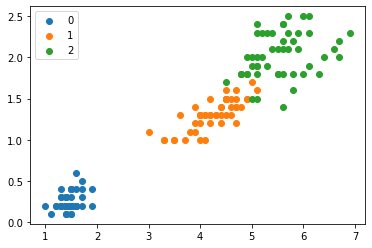

In [65]:
# ax = plt.axes(projection='3d')
# ax.scatter3D(data[:50][column[0]], data[:50][column[1]], data[:50][column[2]],label='0')
# ax.scatter3D(data[50:100][column[0]], data[50:100][column[1]], data[50:100][column[2]],label='1')
# ax.xlabel(column[0])
# ax.ylabel(column[1])
# ax.zlabel(column[2])

# ax.legend()
plt.scatter(data[:50][column[2]], data[:50][column[3]], label = '0')
plt.scatter(data[50:100][column[2]], data[50:100][column[3]], label = '1')
plt.scatter(data[100:150][column[2]], data[100:150][column[3]], label = '2')
plt.legend()

In [66]:
data = data.values

In [67]:
def distance(x, y, p=2):
    if len(x) == len(y) and len(x) > 1:
        sum = 0
        for i in range(len(x)):
            sum += math.pow(abs(x[i] - y[i]), p)
        return math.pow(sum, 1 / p)
    else:
        return 0

In [68]:
class KNN:
    def __init__(self, k, p, x_train, y_train):
        self.k = k
        self.p = p
        self.x_train = x_train
        self.y_train = y_train
            
    def predict(self, x_test):
        knn_list = []
        
        # 先将list装满k个元素
        for i in range(self.k):
            knn_list.append((distance(self.x_train[i], x_test, self.p), self.y_train[i]))
        
        for i in range(self.k, self.x_train.shape[0]):
            max_index = knn_list.index(max(knn_list, key=lambda x: x[0]))
            dis = distance(self.x_train[i], x_test, self.p)
            if dis < knn_list[max_index][0]:
                knn_list[max_index] = (dis, self.y_train[i])
        
        # dict_class {类别 : 类别出现次数}
        dict_class = {}
#         max_cnt = 0
        for i in range(self.k):
            if dict_class.get(knn_list[i][1]) != None:
                dict_class[knn_list[i][1]] += 1
            else:
                dict_class[knn_list[i][1]] = 1
#             max_cnt = max(max_cnt, dict_class[knn_list[i][1]])
        
        # 返回value最大的key
        return max(dict_class.items(), key=lambda x: x[1])[0]
        
    def score(self, x_test, y_test):
        correct_count = 0
        for i in range(len(x_test)):
            if self.predict(x_test[i]) == y_test[i]:
                correct_count += 1
        return correct_count / len(x_test)

In [69]:
# print(data.shape)
model = KNN(3, 2, data[:,2:], target)
test_point = []
test_point.append((6,2))
print(model.predict(test_point[0]))

2


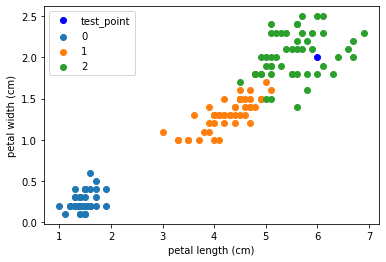

In [73]:
plt.scatter(data[:50][:,2], data[:50][:,3], label = '0')
plt.scatter(data[50:100][:,2], data[50:100][:,3], label = '1')
plt.scatter(data[100:150][:,2], data[100:150][:,3], label = '2')
plt.plot(test_point[0][0], test_point[0][1], 'bo', label='test_point')
plt.xlabel(column[2])
plt.ylabel(column[3])
plt.legend()

### KD树实现

In [152]:
class KD_Node:  # KD树中结点
    def __init__(self, node, split_dim, left, right, visit):
        self.node = node  # k维向量空间结点
        self.split_dim = split_dim  # 分割维度
        self.left = left  # 左孩子
        self.right = right  # 右孩子
        self.visit = visit  # 访问标记位
        
class KD_Tree:  # KD树
    def __init__(self, data):
        k = len(data[0])  # 数据维度
        
        def Create_Tree(split_dim, data):
            if len(data) == 0:
                return None
            data.sort(key = lambda x: x[split_dim])  # 首先在当前维度对数据点进行排序
            split_pos = len(data) // 2  # 取中间点进行分割
            mid_node = data[split_pos]
            split_next_dim = (split_dim + 1) % len(data[0])  # 计算下一分割维度（加一取模）
            
            # 递归的创建kd树
            return KD_Node(mid_node, 
                           split_dim, 
                           Create_Tree(split_next_dim, data[:split_pos]),  # split_pos左面的数据创建左子树
                           Create_Tree(split_next_dim, data[split_pos+1:]),  # split_pos右面的数据创建右子树
                           0)
        
        self.root = Create_Tree(0, data)
        
    # 前序遍历
    def Preorder_Traverse(self, node):
        if node is None:
            return
        print(node.node)
        self.Preorder_Traverse(node.left)
        self.Preorder_Traverse(node.right)
        

In [164]:
# 对目标点进行KD树的k近邻搜索
def Search_KDTree(tree, point, k):
    k_res = []
    
    def Find_Leaf(tree_node, point, k, k_res):  # 找出包含目标点的叶子结点
        if tree_node == None:  # 当前结点为空则直接返回
            return
#         print(tree_node.visit)
        if tree_node.visit == 1 or (tree_node.left == None and tree_node.right == None):  # 判断当前结点是否为叶子结点
            eur_dis = distance(point, tree_node.node, 2)  # 目标点和叶子结点间欧式距离
            # 判断当前叶子结点是否加入列表中
            if len(k_res) < k :  # 列表里不足k各元素则直接加入列表中
                k_res.append((tree_node.node, eur_dis))  # 列表中元素为（结点，与目标结点欧式距离）
#                 print(tree_node.node)
                k_res.sort(key = lambda x: x[1])  # 对列表中结点与目标结点欧式距离进行排序
            else:
                if eur_dis < k_res[-1][1]:  # 比较当前欧式距离和列表中最后一项的欧式距离（列表中的最大距离）
                    k_res[-1] = ((tree_node.node, eur_dis))  # 更新列表中最后一项
                    k_res.sort(key = lambda x: x[1])
            return
       
        dim = tree_node.split_dim  # 获取该结点的切分维度
        if point[dim] < tree_node.node[dim]:  # 若目标点在当前维坐标小于切分点坐标，向左孩子遍历
            Find_Leaf(tree_node.left, point, k, k_res)  # 找到的叶子结点
            other_side = tree_node.right  # 记录另外一侧子树
        else:                            # 若目标点在当前维坐标大于切分点坐标，向右孩子遍历
            Find_Leaf(tree_node.right, point, k, k_res)  
            other_side = tree_node.left
#             print(other_side.node)    
                
        '''cur_dis = distance(point, tree_node.node, 2)  # 目标点与切分点的距离
        if len(k_res) < k :  # 判断当前切分点是否加入列表中
            k_res.append((tree_node.node, cur_dis))
            k_res.sort(key = lambda x: x[1])
        else:
            if cur_dis < k_res[-1][1]: 
                k_res[-1] = ((tree_node.node, cur_dis))
                k_res.sort(key = lambda x: x[1])
        '''
        tree_node.visit = 1
        Find_Leaf(tree_node, point, k, k_res)
        split_dis = abs(tree_node.node[dim] - point[dim])  # 目标点与分割线的距离
        if len(k_res) < k or split_dis < k_res[-1][1]:  # 若不足k个元素或与分割线距离小于列表中最远距离
            Find_Leaf(other_side, point, k, k_res)
        
    Find_Leaf(tree.root, point, k, k_res)
    return k_res 


No handles with labels found to put in legend.


[7, 2]
[5, 4]
[2, 3]
[4, 7]
[9, 6]
[8, 1]


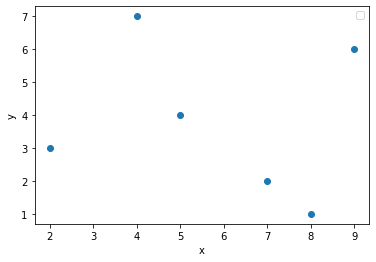

In [168]:
data = [[2,3],[5,4],[9,6],[4,7],[8,1],[7,2]]
kd = KD_Tree(data)
kd.Preorder_Traverse(kd.root)
plt.scatter([i[0] for i in data], [i[1] for i in data])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

([2, 3], 1.8027756377319946)
([5, 4], 2.0615528128088303)
([4, 7], 2.692582403567252)


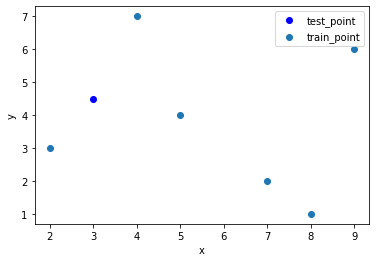

In [169]:
test_point = (3, 4.5)
k_near = Search_KDTree(kd, test_point, 3)
plt.scatter([i[0] for i in data], [i[1] for i in data], label = 'train_point')
plt.plot(test_point[0], test_point[1], 'bo',  label = 'test_point')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
print(*k_near, sep='\n')  # 输出列表中所有元素，每个元素间用换行分隔